# Prophet 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn.metrics import mean_absolute_error
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_yearly, plot_weekly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from itertools import product

import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [8]:
plt.rcParams["figure.figsize"] = (9,6)

## Basic forecasting with Prophet 

Source of data: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [9]:
df = pd.read_csv('data/household_power_consumption.csv')

df.head()

,datetime,Global_active_power
0,2006-12-16 18:00:00,217.932
1,2006-12-16 19:00:00,204.014
2,2006-12-16 20:00:00,196.114
3,2006-12-16 21:00:00,183.388
4,2006-12-16 22:00:00,132.008


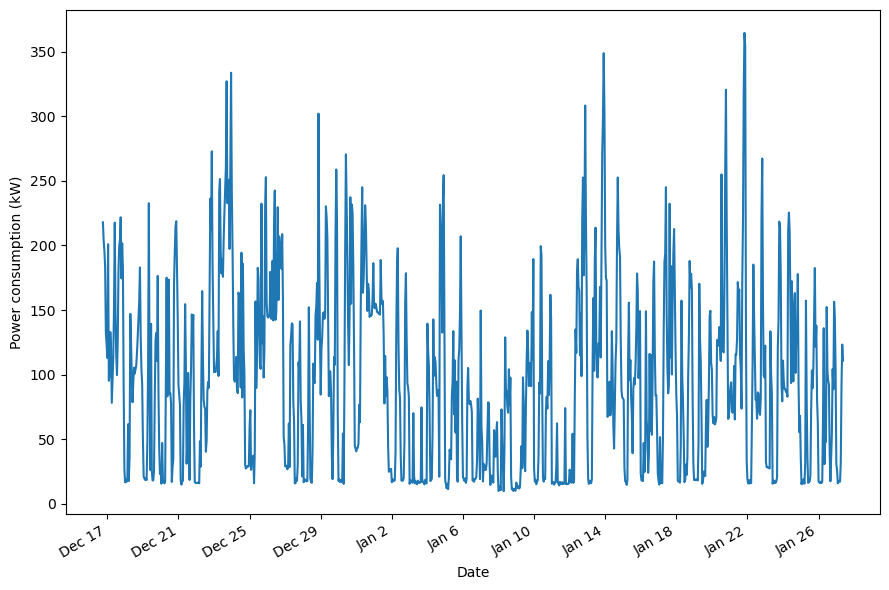

In [10]:
fig, ax = plt.subplots()

ax.plot(df['Global_active_power'])
ax.set_xlabel('Date')
ax.set_ylabel('Power consumption (kW)')

plt.xticks(np.arange(6, 999, 96), ['Dec 17', 'Dec 21', 'Dec 25', 'Dec 29', 'Jan 2', 'Jan 6', 'Jan 10', 'Jan 14', 'Jan 18', 'Jan 22', 'Jan 26'])

fig.autofmt_xdate()
plt.tight_layout()

### Rename columns appropriately 

In [11]:
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2006-12-16 18:00:00,217.932
1,2006-12-16 19:00:00,204.014
2,2006-12-16 20:00:00,196.114
3,2006-12-16 21:00:00,183.388
4,2006-12-16 22:00:00,132.008


### Train/test split 

In [12]:
train = df[:-168]
test = df[-168:]

### Initialize model and fit 

In [13]:
m = Prophet()
m.fit(train);

17:10:17 - cmdstanpy - INFO - Chain [1] start processing
17:10:18 - cmdstanpy - INFO - Chain [1] done processing


### Make *future* DataFrame 

In [14]:
future = m.make_future_dataframe(periods=168, freq='H')

### Forecast 

In [15]:
future.tail()

,ds
995,2007-01-27 05:00:00
996,2007-01-27 06:00:00
997,2007-01-27 07:00:00
998,2007-01-27 08:00:00
999,2007-01-27 09:00:00


In [16]:
forecast = m.predict(future)

In [17]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
995,2007-01-27 05:00:00,114.831334,21.040112,167.538646,110.223680,119.702299,-18.090366,-18.090366,-18.090366,-45.433684,-45.433684,-45.433684,27.343318,27.343318,27.343318,0.0,0.0,0.0,96.740968
996,2007-01-27 06:00:00,114.924295,40.328289,194.874832,110.282125,119.837379,2.678245,2.678245,2.678245,-26.388445,-26.388445,-26.388445,29.066690,29.066690,29.066690,0.0,0.0,0.0,117.602539
997,2007-01-27 07:00:00,115.017255,76.039573,221.883948,110.320933,119.972459,31.310218,31.310218,31.310218,0.590197,0.590197,0.590197,30.720021,30.720021,30.720021,0.0,0.0,0.0,146.327473
998,2007-01-27 08:00:00,115.110215,95.584803,244.886083,110.363525,120.107539,56.768926,56.768926,56.768926,24.477380,24.477380,24.477380,32.291547,32.291547,32.291547,0.0,0.0,0.0,171.879142
999,2007-01-27 09:00:00,115.203176,107.337051,259.124091,110.408043,120.274468,67.860301,67.860301,67.860301,34.090505,34.090505,34.090505,33.769796,33.769796,33.769796,0.0,0.0,0.0,183.063477


### Evaluate against a baseline

In [18]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]

test.head()

,ds,y,yhat,yhat_lower,yhat_upper
832,2007-01-20 10:00:00,136.784,161.141511,85.175046,232.650907
833,2007-01-20 11:00:00,124.536,144.581678,68.834955,218.135703
834,2007-01-20 12:00:00,110.588,129.708219,55.597401,204.911718
835,2007-01-20 13:00:00,255.062,124.638157,47.239132,199.147389
836,2007-01-20 14:00:00,158.022,129.493102,56.521652,198.405908


In [19]:
test['baseline'] = train['y'][-168:].values

test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline
832,2007-01-20 10:00:00,136.784,161.141511,85.175046,232.650907,190.202
833,2007-01-20 11:00:00,124.536,144.581678,68.834955,218.135703,213.784
834,2007-01-20 12:00:00,110.588,129.708219,55.597401,204.911718,118.210
835,2007-01-20 13:00:00,255.062,124.638157,47.239132,199.147389,98.352
836,2007-01-20 14:00:00,158.022,129.493102,56.521652,198.405908,97.782


In [20]:
prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

print(prophet_mae)
print(baseline_mae)

46.56828155900314
47.146928571428575


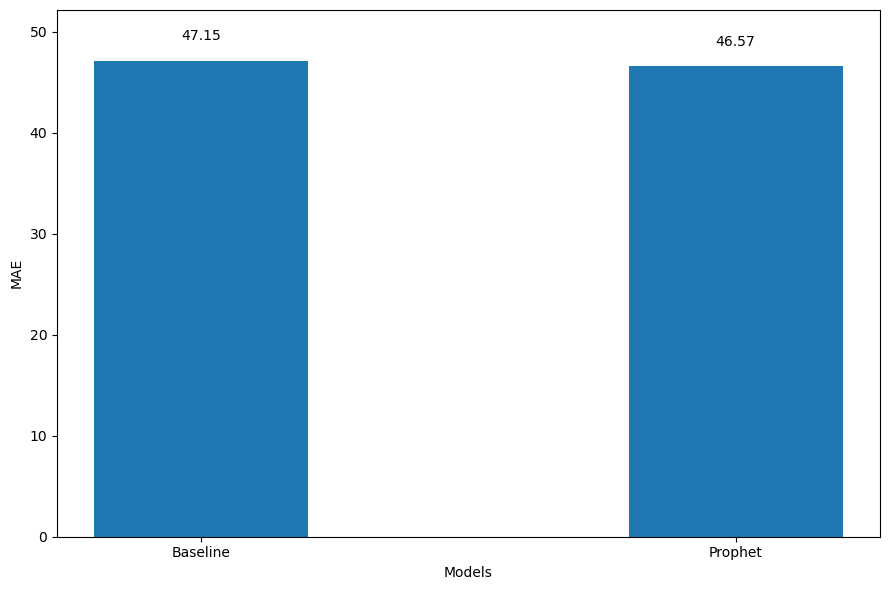

In [21]:
fig, ax = plt.subplots()

x = ['Baseline', 'Prophet']
y = [baseline_mae, prophet_mae]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, max(y) + 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 2, s=str(round(value,2)), ha='center')

plt.tight_layout()

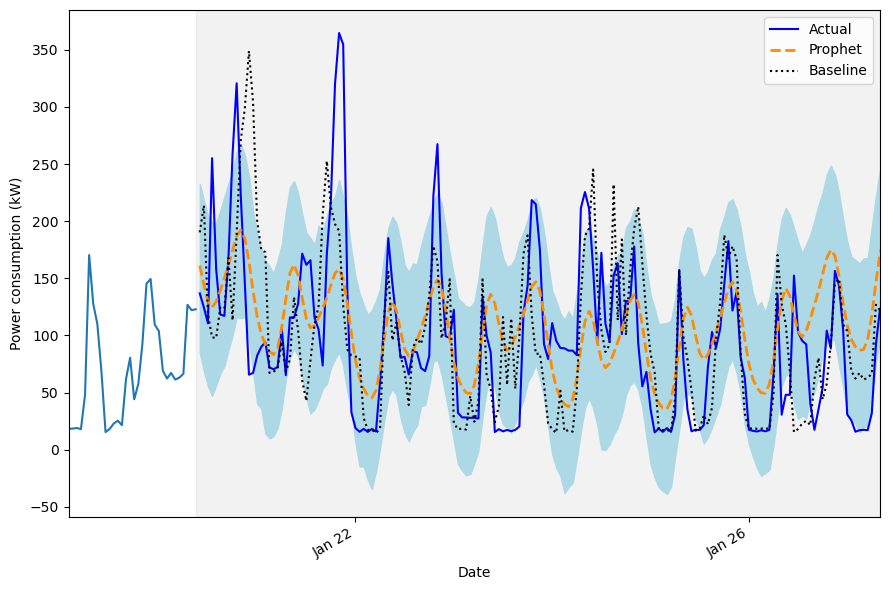

In [22]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=2, label='Prophet')
ax.plot(test['baseline'], 'k:', label='Baseline')

ax.set_xlabel('Date')
ax.set_ylabel('Power consumption (kW)')

ax.axvspan(831, 998, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(6, 999, 96), ['Dec 17', 'Dec 21', 'Dec 25', 'Dec 29', 'Jan 2', 'Jan 6', 'Jan 10', 'Jan 14', 'Jan 18', 'Jan 22', 'Jan 26'])

plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')

plt.xlim(800, 998)

fig.autofmt_xdate()
plt.tight_layout()

## Prophet's advanced functionalities 

### Visualizations 

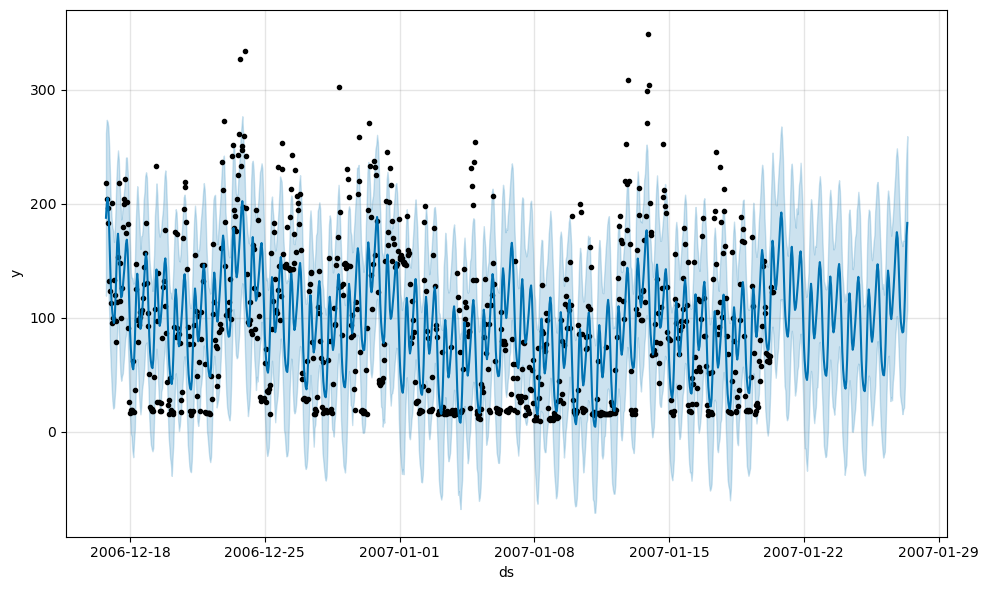

In [23]:
fig1 = m.plot(forecast)

#### Plot components 

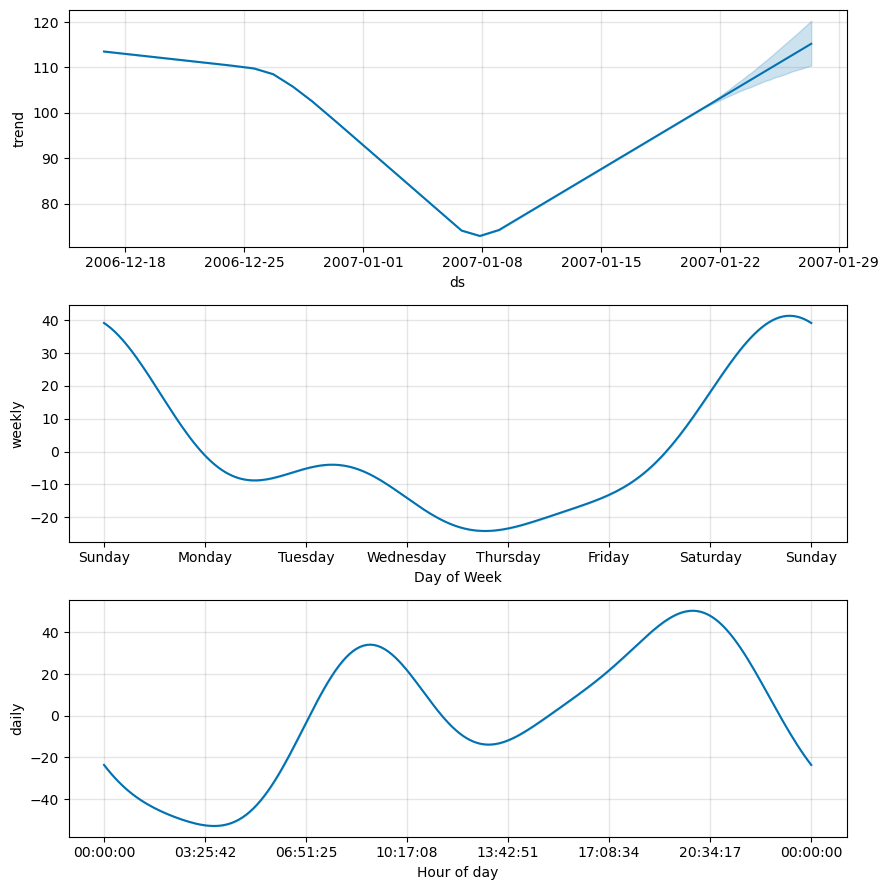

In [24]:
fig2 = m.plot_components(forecast)

#### Show trend changepoints 

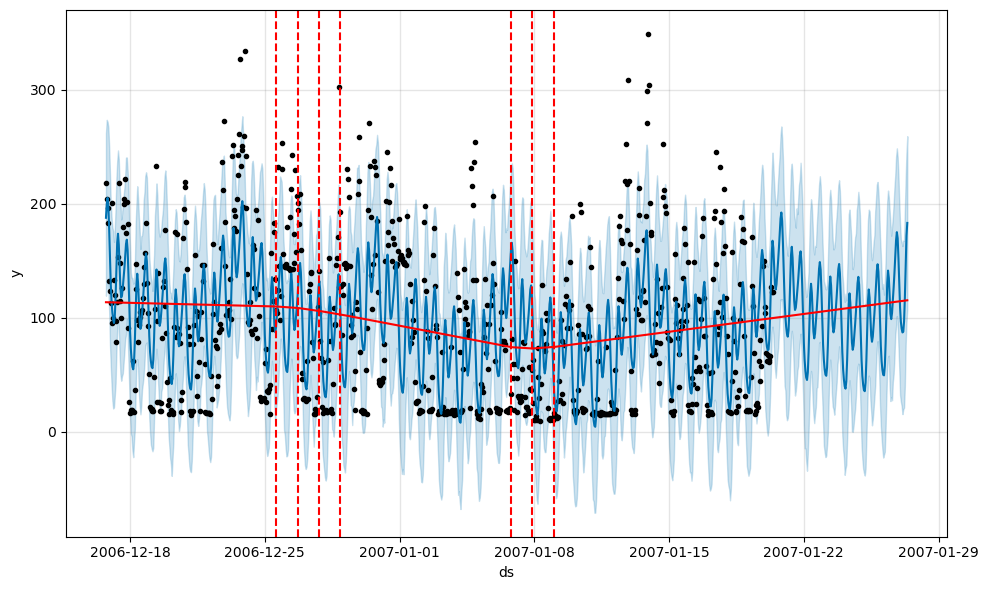

In [26]:
fig3 = m.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), m, forecast)

#### Plot seasonal components separately 

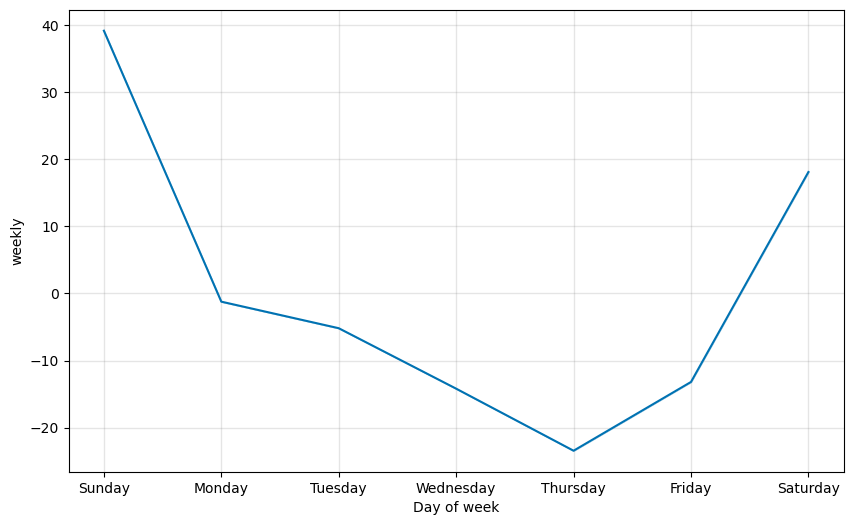

In [28]:
fig4 = plot_weekly(m)

#### Tune seasonality's sensitivity 

17:10:50 - cmdstanpy - INFO - Chain [1] start processing
17:10:51 - cmdstanpy - INFO - Chain [1] done processing


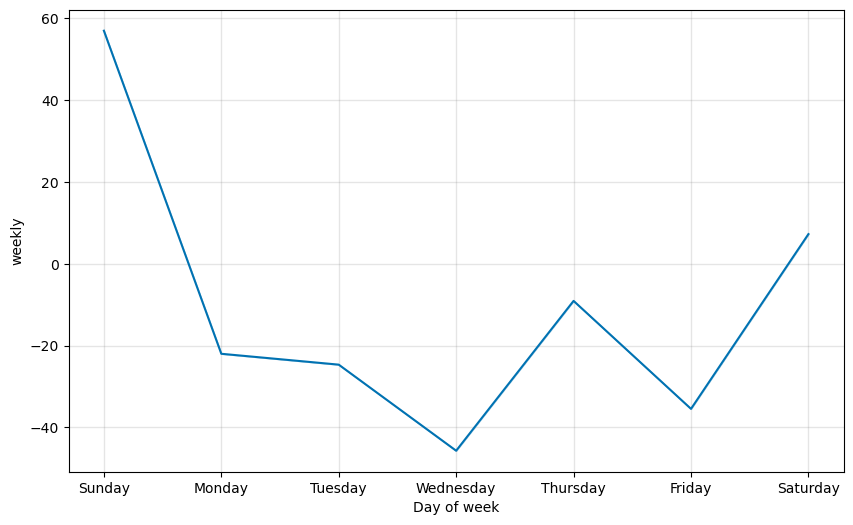

In [29]:
m2 = Prophet(weekly_seasonality=20).fit(train)

fig6 = plot_weekly(m2)

### Cross-validation and performance metrics 

In [31]:
df_cv = cross_validation(m, initial='504 hours', period='84 hours', horizon='168 hours', parallel='processes')

df_cv.head()

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
17:11:00 - cmdstanpy - INFO - Chain [1] start processing
17:11:00 - cmdstanpy - INFO - Chain [1] start processing
17:11:00 - cmdstanpy - INFO - Chain [1] done processing
17:11:00 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2007-01-09 22:00:00,30.785758,-41.155691,101.636425,111.454,2007-01-09 21:00:00
1,2007-01-09 23:00:00,3.152348,-65.992386,78.812384,189.508,2007-01-09 21:00:00
2,2007-01-10 00:00:00,-17.338653,-89.350290,58.021320,27.360,2007-01-09 21:00:00
3,2007-01-10 01:00:00,-28.502854,-100.655819,44.716198,17.178,2007-01-09 21:00:00
4,2007-01-10 02:00:00,-34.884531,-107.763638,36.991021,18.650,2007-01-09 21:00:00


In [33]:
df_perf = performance_metrics(df_cv, rolling_window=0)

df_perf.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 01:00:00,5561.550151,74.575801,74.303721,0.540488,0.540488,0.784559,0.5
1,0 days 02:00:00,23097.740513,151.979408,146.719987,0.742133,0.742133,1.301409,0.0
2,0 days 03:00:00,1361.894445,36.903854,35.819844,0.930815,0.930815,1.128610,1.0
3,0 days 04:00:00,1151.950922,33.940402,30.208626,1.404549,1.404549,1.080984,1.0
4,0 days 05:00:00,1522.131043,39.014498,33.444017,1.503524,1.503524,1.073286,1.0


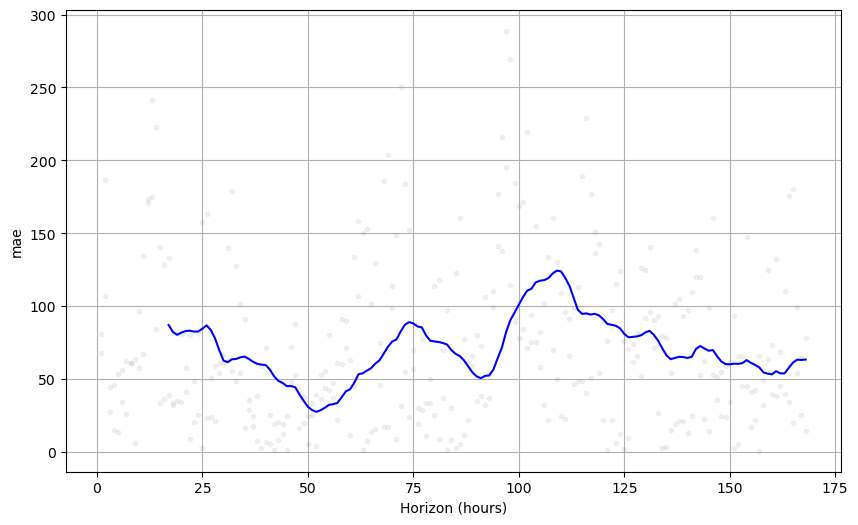

In [35]:
fig7 = plot_cross_validation_metric(df_cv, metric='mae')

### Hyperparameter tuning 

In [36]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

maes = []

for params in all_params:
    m = Prophet(**params).fit(train)
    df_cv = cross_validation(m, initial='504 hours', period='84 hours', horizon='168 hours', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes

tuning_results

17:11:15 - cmdstanpy - INFO - Chain [1] start processing
17:11:15 - cmdstanpy - INFO - Chain [1] done processing
17:11:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:11:15 - cmdstanpy - INFO - Chain [1] start processing
17:11:17 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
17:11:19 - cmdstanpy - INFO - Chain [1] start processing
17:11:19 - cmdstanpy - INFO - Chain [1] start processing
17:11:19 - cmdstanpy - INFO - Chain [1] done processing
17:11:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:11:19 - cmdstanpy - INFO - Chain [1] done processing
17:11:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated 

17:11:53 - cmdstanpy - INFO - Chain [1] start processing
17:11:53 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
17:11:55 - cmdstanpy - INFO - Chain [1] start processing
17:11:55 - cmdstanpy - INFO - Chain [1] start processing
17:11:55 - cmdstanpy - INFO - Chain [1] done processing
17:11:55 - cmdstanpy - INFO - Chain [1] done processing
17:11:55 - cmdstanpy - INFO - Chain [1] start processing
17:11:56 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
17:11:58 - cmdstanpy - INFO - Chain [1] start processing
17:11:58 - cmdstanpy - INFO - Chain [1] start processing
17:11:58 - cmdstanpy - INFO - Chain [1] done processing
17:11:58 - cmdstanpy - INFO - Chain [1] done processing
17:11:58 - cmdstanpy - INFO - Chain [1] start processing
17:11:58 - cmdstanpy - INFO - Cha

,changepoint_prior_scale,seasonality_prior_scale,mae
0,0.001,0.01,54.609913
1,0.001,0.10,53.013355
2,0.001,1.00,53.239080
3,0.001,10.00,53.348743
4,0.010,0.01,56.381313
5,0.010,0.10,54.685216
6,0.010,1.00,55.456725
7,0.010,10.00,55.949644
8,0.100,0.01,66.184181
9,0.100,0.10,68.182415


In [37]:
best_params = all_params[np.argmin(maes)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}
